<a href="https://colab.research.google.com/github/vaelkokach/amazon-sagemaker-/blob/main/PreTrain_Transformers_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# © Copyright 2020 [AAAASTARK](https://github.com/aaaastark).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aaaastark/Pretrain_Finetune_Transformers_Pytorch/blob/master/PreTrain_Transformers_Pytorch.ipynb) &nbsp;
[![Generic badge](https://img.shields.io/badge/GitHub-Source-greensvg)](https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch/blob/master/PreTrain_Transformers_Pytorch.ipynb)
[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

# **Pre-Training Transformers Models in PyTorch with Hugging Face Transformers**

> **Train 67 transformers models on your specific dataset.**

---

**Note:** *I've structured this tutorial notebook similarly to my other ones intentionally, aiming to maintain consistency for readers.*

---

This notebook serves the purpose of training transformers models using [Huggingface](https://huggingface.co/transformers/) with your custom dataset.

With the AutoClasses feature, we can utilize the code across a wide range of transformers models!

This notebook is designed to:

* **Utilize a pretrained transformers model and fine-tune it on your custom dataset.**

* **Train a transformer model from scratch on a custom dataset.** This necessitates a pre-trained tokenizer. If one isn't provided, this notebook defaults to using the pretrained tokenizer.

This notebook draws heavy inspiration from the Hugging Face script used for training language models: [transformers/tree/master/examples/language-modeling](https://github.com/huggingface/transformers/tree/master/examples/language-modeling). I've essentially adapted that script to function smoothly within a notebook, with numerous comments for clarity.

**Key Points from [transformers/tree/master/examples/language-modeling](https://github.com/huggingface/transformers/tree/master/examples/language-modeling):** *Fine-tuning library models for language modeling on a text file (GPT, GPT-2, CTRL, BERT, RoBERTa, XLNet).
GPT, GPT-2, and CTRL are fine-tuned using a causal language modeling (CLM) loss. BERT and RoBERTa are fine-tuned using a masked language modeling (MLM) loss. XLNet is fine-tuned using a permutation language modeling (PLM) loss.*

---

## **What Prerequisites Do I Need for This Notebook?**

Given that I'm using PyTorch for fine-tuning our transformers models, any familiarity with PyTorch is beneficial.

A basic understanding of the [transformers](https://github.com/huggingface/transformers) library would also be advantageous.

In this notebook, **I'm using raw text data to train / fine-tune transformers models** (when using a pretrained model, I refer to this as "extended pretraining" since I 'continue' the original training of the model on a custom dataset). Since we're not engaged in classification, labeled data isn't necessary. The Transformers library manages the text files similarly to the original implementation of each model.

---

## **How Can I Utilize This Notebook?**

As with any project, I've designed this notebook with reusability in mind. It retrieves the custom dataset from `.txt` files. Since the dataset isn't contained within a single `.txt` file, I've created a custom function, `movie_reviews_to_file`, which reads the dataset and generates the `text` file. The method of loading the `.txt` files can be readily adapted for any other dataset.

The only modifications required to use your own dataset will be in the paths provided to the training `.txt` file and evaluation `.txt` file.

All modifiable parameters are located under the **Parameters Setup** section. Each parameter is thoroughly commented and structured for ease of understanding.

---

## **Which transformers Models Are Compatible with This Notebook?**

While many individuals may primarily use it for BERT, it's essential to know which other transformer model architectures are compatible with this code. Since the notebook's name is **Training Transformers**, it should function with more than one type of transformer.

I've tested this notebook across all the pretrained models available on Hugging Face Transformer. This way, you'll know in advance if the model you plan to use works seamlessly with this code, requiring no modifications.

You can find the list of pretrained transformers models that work with this notebook under `Training Transformers with Pytorch`. A total of **67 models succeeded** 😄, while 39 models encountered failures 😢 when used with this notebook. *Remember, these are pretrained models fine-tuned on a custom dataset.*

---

## **Dataset**

This notebook focuses on pretraining transformers on a custom dataset. Specifically, I'll utilize the well-known movies reviews positive-negative labeled [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

Here's the description provided on the Stanford website:

*This dataset is for binary sentiment classification, containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. There is additional unlabeled data available as well. Raw text and already processed bag of words formats are provided. Refer to the README file contained in the release for more details.*

**Why this dataset?** I believe it's an easily understandable and usable dataset for classification. Sentiment data is always engaging to work with.

---

## **Coding**

Now, let's dive into some coding! We'll walk through each code cell in the notebook, describing its purpose, the code within it, and when relevant, showcasing the output.

I've formatted this guide to be easy to follow along, should you decide to run each code cell in your own Python notebook.

When I learn from a tutorial, I always aim to replicate the results. Having the code alongside the explanations makes it easier to follow along.

## **Downloads**

Download the *Large Movie Review Dataset* and unzip it locally.


In [1]:
# Download the dataset.
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip the dataset.
!tar -zxf /content/aclImdb_v1.tar.gz

In [8]:
!pip install --upgrade transformers


## **Installs**

* **[transformers](https://github.com/huggingface/transformers)** library needs to be installed to use all the awesome code from Hugging Face. To get the latest version I will install it straight from GitHub.

* **[Pretrain_Finetune_Transformers_Pytorch](https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch)** library used for various transformers related tasks. I created this library to reduce the amount of code I need to write for each transformers project.


In [2]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: git+https://github.com/aaaastark/Pretrain_Finetune_Transformers_Pytorch.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [48]:
"""Functions that deal with text/string"""

import re
import copy
import string


def clean_text(text, full_clean=False, punctuation=False, numbers=False, lower=False, extra_spaces=False,
               control_characters=False, tokenize_whitespace=False, remove_characters=''):
    r"""
    Clean text using various techniques.

    I took inspiration from the cleantext library `https://github.com/prasanthg3/cleantext`. I did not like the whole
    implementation so I made my own changes.

    Note:
        As in the original cleantext library I will add: stop words removal, stemming and
        negative-positive words removal.

    Arguments:

        text (:obj:`str`):
            String that needs cleaning.

        full_clean (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Remove: punctuation, numbers, extra space, control characters and lower case. This argument is optional and
            it has a default value attributed inside the function.

        punctuation (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Remove punctuation from text. This argument is optional and it has a default value attributed inside
            the function.

        numbers (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Remove digits from text. This argument is optional and it has a default value attributed inside
            the function.

        lower (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Lower case all text. This argument is optional and it has a default value attributed inside the function.

        extra_spaces (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Remove extra spaces - everything beyond one space. This argument is optional and it has a default value
            attributed inside the function.

        control_characters (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Remove characters like `\n`, `\t` etc.This argument is optional and it has a default value attributed
            inside the function.

        tokenize_whitespace (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Return a list of tokens split on whitespace. This argument is optional and it has a default value
            attributed inside the function.

        remove_characters (:obj:`str`, `optional`, defaults to :obj:`''`):
            Remove defined characters form text. This argument is optional and it has a default value attributed
            inside the function.

    Returns:

        :obj:`str`: Clean string.

    Raises:

        ValueError: If `text` is not of type string.

        ValueError: If `remove_characters` needs to be a string.

    """

    if not isinstance(text, str):
        # `text` is not type of string
        raise ValueError("`text` is not of type str!")

    if not isinstance(remove_characters, str):
        # remove characters need to be a string
        raise ValueError("`remove_characters` needs to be a string!")

    # all control characters like `\t` `\n` `\r` etc.
    # Stack Overflow: https://stackoverflow.com/a/8115378/11281368
    control_characters_list = ''.join([chr(char) for char in range(1, 32)])

    # define control characters table
    table_control_characters = str.maketrans(dict.fromkeys(control_characters_list))

    # remove punctuation table
    table_punctuation = str.maketrans(dict.fromkeys(string.punctuation))

    # remove numbers table
    table_digits = str.maketrans(dict.fromkeys('0123456789'))

    # remove certain characters table
    table_remove_characters = str.maketrans(dict.fromkeys(remove_characters))

    # make a copy of text to make sure it doesn't affect original text
    cleaned = copy.deepcopy(text)

    if full_clean or punctuation:
        # remove punctuation
        cleaned = cleaned.translate(table_punctuation)

    if full_clean or numbers:
        # remove numbers
        cleaned = cleaned.translate(table_digits)

    if full_clean or extra_spaces:
        # remove extra spaces - also removes control characters
        # Stack Overflow https://stackoverflow.com/a/2077906/11281368
        cleaned = re.sub('\s+', ' ', cleaned).strip()

    if full_clean or lower:
        # lowercase
        cleaned = cleaned.lower()

    if control_characters:
        # remove control characters
        cleaned = cleaned.translate(table_control_characters)

    if tokenize_whitespace:
        # tokenizes text n whitespace
        cleaned = re.split('\s+', cleaned)

    if remove_characters:
        # remove these characters from text
        cleaned = cleaned.translate(table_remove_characters)

    return cleaned

In [4]:
import re
import matplotlib.pyplot as plt

# ———————— Text “fixing” helper ————————
def fix_text(text: str) -> str:
    """
    Minimal normalization: collapse whitespace, strip leading/trailing spaces.
    You can tweak this to remove weird artifacts as needed.
    """
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# ———————— Plotting helper ————————
def plot_history(history, metrics=('loss', 'accuracy')):
    """
    Plots train vs. validation curves for each metric in `metrics`,
    expecting a Keras History object.
    """
    for m in metrics:
        train_vals = history.history[m]
        val_vals   = history.history.get(f'val_{m}')
        plt.plot(train_vals, label=f'train_{m}')
        if val_vals is not None:
            plt.plot(val_vals,   label=f'val_{m}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


## **Imports**

Import all needed libraries for this notebook.

Declare basic parameters used for this notebook:

* `set_seed(123)` - Always good to set a fixed seed for reproducibility.

* `device` - Look for gpu to use. I will use cpu by default if no gpu found.

In [5]:
import io
import os
import math
import torch
import warnings
from tqdm.notebook import tqdm
#from pretrain_finetune_transformers_pytorch import plot_dict, fix_text
from transformers import (
                          CONFIG_MAPPING,
                          MODEL_FOR_MASKED_LM_MAPPING,
                          MODEL_FOR_CAUSAL_LM_MAPPING,
                          PreTrainedTokenizer,
                          TrainingArguments,
                          AutoConfig,
                          AutoTokenizer,
                          AutoModelWithLMHead,
                          AutoModelForCausalLM,
                          AutoModelForMaskedLM,
                          LineByLineTextDataset,
                          TextDataset,
                          DataCollatorForLanguageModeling,
                          DataCollatorForWholeWordMask,
                          DataCollatorForPermutationLanguageModeling,
                          PretrainedConfig,
                          Trainer,
                          set_seed,
                          )

# Set seed for reproducibility,
set_seed(123)

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## **Helper Functions**

I prefer to gather all the Classes and functions we'll use in this notebook under this section to keep things organized:

**movie_reviews_to_file(path_data: str, path_texts_file: str)**

This function consolidates all the data from the Large Movie Review Dataset into a single `.txt` file, making it easier to work with in this notebook. Each example is saved on a separate line in the file. You'll need to provide the `path_data` to where the data files are located, and `path_texts_file` will be the location and name of the resulting `.txt` file.

<br>

**ModelDataArguments**

This class mimics the format used in the [transformers](https://github.com/huggingface/transformers) library. The key difference is that it combines multiple types of arguments into one, ensuring that the settings are correctly configured. Here's a breakdown of all the arguments (they're also documented within the class):

* `train_data_file`:
  *Path to your `.txt` dataset file. If each example is on a separate line, set `line_by_line=True`. If the file contains continuous text without separation, set `line_by_line=False` and a window of `block_size` will be moved across the text.*

* `eval_data_file`:
  *Path to the evaluation `.txt` file, following the same format as `train_data_file`.*

* `line_by_line`:
  *Set to `True` if each example is on a separate line in the train and eval files. If not, set to `False`, and a window of `block_size` will be used to extract examples.*

* `mlm`:
  *A flag indicating whether the model is a masked language model (e.g., BERT or RoBERTa). Set to `True` for these models, `False` otherwise.*

* `whole_word_mask`:
  *Determines whether to use whole word masking during training. If `True`, entire words will be masked instead of individual tokens.*

* `mlm_probability`:
  *Probability of masking tokens during training, used with `mlm=True`.*

* `plm_probability`:
  *Defines the ratio of the length of a masked token span to the surrounding context length for permutation language modeling, primarily used for XLNet.*

* `max_span_length`:
  *Limits the length of a masked token span used for permutation language modeling, primarily used for XLNet.*

* `block_size`:
  *The window size moved across the text file. Set to -1 for maximum allowed length.*

* `overwrite_cache`:
  *Overwrites any cached files if they exist.*

* `model_type`:
  *Type of model being used: BERT, RoBERTa, GPT-2, etc.*

* `model_config_name`:
  *Model configuration being used: BERT, RoBERTa, GPT-2, etc.*

* `tokenizer_name`:
  *Tokenizer used to process data for training, usually named after the model (e.g., bert-base-cased, roberta-base, gpt2).*

* `model_name_or_path`:
  *Path to an existing transformer model or the name of the transformer model being used (e.g., bert-base-cased, roberta-base, gpt2).*

* `model_cache_dir`:
  *Path to cache files, which helps save time when re-running code.*

<br>

**get_model_config(args: ModelDataArguments)**

Retrieves the model configuration based on the provided ModelDataArguments. It raises a ValueError if `mlm=True` but `model_type` is not one of ["bert", "roberta", "distilbert", "camembert"], as masked language models require this setting.

<br>

**get_tokenizer(args: ModelDataArguments)**

Retrieves the model tokenizer based on the provided ModelDataArguments, adjusting the `block_size` if necessary.

<br>

**get_model(args: ModelDataArguments, model_config)**

Retrieves the actual model based on the provided ModelDataArguments and model configuration.

<br>

**get_dataset(args: ModelDataArguments, tokenizer: PreTrainedTokenizer, evaluate: bool=False)**

Processes the dataset file into a PyTorch Dataset based on the provided ModelDataArguments and tokenizer. If `evaluate` is set to `True`, it handles the test/validation file; otherwise, it handles the training file.

<br>

**get_collator(args: ModelDataArguments, model_config: PretrainedConfig, tokenizer: PreTrainedTokenizer)**

Retrieves the appropriate collator function for use in collating a PyTorch Dataset object, based on the provided ModelDataArguments, model configuration, and tokenizer.

In [6]:
def movie_reviews_to_file(path_data: str, path_texts_file: str):
  r"""Reading in all data from path and saving it into a single `.txt` file.

  In the pretraining process of our transformers model we require a text file.

  This function is designed to work for the Movie Reviews Dataset.
  You wil have to create your own function to move all examples into a text
  file if you don't already have a text file with all your unlabeled data.

  Arguments:

      path_data (:obj:`str`):
        Path to the Movie Review Dataset partition. We only have `\train` and
        `test` partitions.

      path_texts_file (:obj:`str`):
        File path of the generated `.txt` file that contains one example / line.

  """

  # Check if path exists.
  if not os.path.isdir(path_data):
    # Raise error if path is invalid.
    raise ValueError('Invalid `path` variable! Needs to be a directory')
  # Check max sequence length.
  texts = []
  print('Reading `%s` partition...' % (os.path.basename(path_data)))
  # Since the labels are defined by folders with data we loop
  # through each label.
  for label  in ['neg', 'pos']:
    sentiment_path = os.path.join(path_data, label)

    # Get all files from path.
    files_names = os.listdir(sentiment_path)#[:30] # SAMPLE FOR DEBUGGING.
    # Go through each file and read its content.
    for file_name in tqdm(files_names, desc=label, unit='files'):
      file_path = os.path.join(sentiment_path, file_name)

      # Read content.
      content = io.open(file_path, mode='r', encoding='utf-8').read()
      # Fix any unicode issues.
      content = fix_text(content)
      # Save content.
      texts.append(content)
  # Move list to single string.
  all_texts = '\n'.join(texts)
  # Send all texts string to single file.
  io.open(file=path_texts_file, mode='w', encoding='utf-8').write(all_texts)
  # Print when done.
  print('`.txt` file saved in `%s`\n' % path_texts_file)

  return


class ModelDataArguments(object):
  r"""Define model and data configuration needed to perform pretraining.

  Eve though all arguments are optional there still needs to be a certain
  number of arguments that require values attributed.

  Arguments:

    train_data_file (:obj:`str`, `optional`):
      Path to your .txt file dataset. If you have an example on each line of
      the file make sure to use line_by_line=True. If the data file contains
      all text data without any special grouping use line_by_line=False to move
      a block_size window across the text file.
      This argument is optional and it will have a `None` value attributed
      inside the function.

    eval_data_file (:obj:`str`, `optional`):
      Path to evaluation .txt file. It has the same format as train_data_file.
      This argument is optional and it will have a `None` value attributed
      inside the function.

    line_by_line (:obj:`bool`, `optional`, defaults to :obj:`False`):
      If the train_data_file and eval_data_file contains separate examples on
      each line then line_by_line=True. If there is no separation between
      examples and train_data_file and eval_data_file contains continuous text
      then line_by_line=False and a window of block_size will be moved across
      the files to acquire examples.
      This argument is optional and it has a default value.

    mlm (:obj:`bool`, `optional`, defaults to :obj:`False`):
      Is a flag that changes loss function depending on model architecture.
      This variable needs to be set to True when working with masked language
      models like bert or roberta and set to False otherwise. There are
      functions that will raise ValueError if this argument is
      not set accordingly.
      This argument is optional and it has a default value.

    whole_word_mask (:obj:`bool`, `optional`, defaults to :obj:`False`):
      Used as flag to determine if we decide to use whole word masking or not.
      Whole word masking means that whole words will be masked during training
      instead of tokens which can be chunks of words.
      This argument is optional and it has a default value.

    mlm_probability(:obj:`float`, `optional`, defaults to :obj:`0.15`):
      Used when training masked language models. Needs to have mlm set to True.
      It represents the probability of masking tokens when training model.
      This argument is optional and it has a default value.

    plm_probability (:obj:`float`, `optional`, defaults to :obj:`float(1/6)`):
      Flag to define the ratio of length of a span of masked tokens to
      surrounding context length for permutation language modeling.
      Used for XLNet.
      This argument is optional and it has a default value.

    max_span_length (:obj:`int`, `optional`, defaults to :obj:`5`):
      Flag may also be used to limit the length of a span of masked tokens used
      for permutation language modeling. Used for XLNet.
      This argument is optional and it has a default value.

    block_size (:obj:`int`, `optional`, defaults to :obj:`-1`):
      It refers to the windows size that is moved across the text file.
      Set to -1 to use maximum allowed length.
      This argument is optional and it has a default value.

    overwrite_cache (:obj:`bool`, `optional`, defaults to :obj:`False`):
      If there are any cached files, overwrite them.
      This argument is optional and it has a default value.

    model_type (:obj:`str`, `optional`):
      Type of model used: bert, roberta, gpt2.
      More details: https://huggingface.co/transformers/pretrained_models.html
      This argument is optional and it will have a `None` value attributed
      inside the function.

    model_config_name (:obj:`str`, `optional`):
      Config of model used: bert, roberta, gpt2.
      More details: https://huggingface.co/transformers/pretrained_models.html
      This argument is optional and it will have a `None` value attributed
      inside the function.

    tokenizer_name: (:obj:`str`, `optional`)
      Tokenizer used to process data for training the model.
      It usually has same name as model_name_or_path: bert-base-cased,
      roberta-base, gpt2 etc.
      This argument is optional and it will have a `None` value attributed
      inside the function.

    model_name_or_path (:obj:`str`, `optional`):
      Path to existing transformers model or name of
      transformer model to be used: bert-base-cased, roberta-base, gpt2 etc.
      More details: https://huggingface.co/transformers/pretrained_models.html
      This argument is optional and it will have a `None` value attributed
      inside the function.

    model_cache_dir (:obj:`str`, `optional`):
      Path to cache files to save time when re-running code.
      This argument is optional and it will have a `None` value attributed
      inside the function.

  Raises:

        ValueError: If `CONFIG_MAPPING` is not loaded in global variables.

        ValueError: If `model_type` is not present in `CONFIG_MAPPING.keys()`.

        ValueError: If `model_type`, `model_config_name` and
          `model_name_or_path` variables are all `None`. At least one of them
          needs to be set.

        warnings: If `model_config_name` and `model_name_or_path` are both
          `None`, the model will be trained from scratch.

        ValueError: If `tokenizer_name` and `model_name_or_path` are both
          `None`. We need at least one of them set to load tokenizer.

  """

  def __init__(self, train_data_file=None, eval_data_file=None,
               line_by_line=False, mlm=False, mlm_probability=0.15,
               whole_word_mask=False, plm_probability=float(1/6),
               max_span_length=5, block_size=-1, overwrite_cache=False,
               model_type=None, model_config_name=None, tokenizer_name=None,
               model_name_or_path=None, model_cache_dir=None):

    # Make sure CONFIG_MAPPING is imported from transformers module.
    if 'CONFIG_MAPPING' not in globals():
      raise ValueError('Could not find `CONFIG_MAPPING` imported! Make sure' \
                       ' to import it from `transformers` module!')

    # Make sure model_type is valid.
    if (model_type is not None) and (model_type not in CONFIG_MAPPING.keys()):
      raise ValueError('Invalid `model_type`! Use one of the following: %s' %
                       (str(list(CONFIG_MAPPING.keys()))))

    # Make sure that model_type, model_config_name and model_name_or_path
    # variables are not all `None`.
    if not any([model_type, model_config_name, model_name_or_path]):
      raise ValueError('You can`t have all `model_type`, `model_config_name`,' \
                       ' `model_name_or_path` be `None`! You need to have' \
                       'at least one of them set!')

    # Check if a new model will be loaded from scratch.
    if not any([model_config_name, model_name_or_path]):
      # Setup warning to show pretty. This is an overkill
      warnings.formatwarning = lambda message,category,*args,**kwargs: \
                               '%s: %s\n' % (category.__name__, message)
      # Display warning.
      warnings.warn('You are planning to train a model from scratch! 🙀')

    # Check if a new tokenizer wants to be loaded.
    # This feature is not supported!
    if not any([tokenizer_name, model_name_or_path]):
      # Can't train tokenizer from scratch here! Raise error.
      raise ValueError('You want to train tokenizer from scratch! ' \
                    'That is not possible yet! You can train your own ' \
                    'tokenizer separately and use path here to load it!')

    # Set all data related arguments.
    self.train_data_file = train_data_file
    self.eval_data_file = eval_data_file
    self.line_by_line = line_by_line
    self.mlm = mlm
    self.whole_word_mask = whole_word_mask
    self.mlm_probability = mlm_probability
    self.plm_probability = plm_probability
    self.max_span_length = max_span_length
    self.block_size = block_size
    self.overwrite_cache = overwrite_cache

    # Set all model and tokenizer arguments.
    self.model_type = model_type
    self.model_config_name = model_config_name
    self.tokenizer_name = tokenizer_name
    self.model_name_or_path = model_name_or_path
    self.model_cache_dir = model_cache_dir
    return


def get_model_config(args: ModelDataArguments):
  r"""
  Get model configuration.

  Using the ModelDataArguments return the model configuration.

  Arguments:

    args (:obj:`ModelDataArguments`):
      Model and data configuration arguments needed to perform pretraining.

  Returns:

    :obj:`PretrainedConfig`: Model transformers configuration.

  Raises:

    ValueError: If `mlm=True` and `model_type` is NOT in ["bert",
          "roberta", "distilbert", "camembert"]. We need to use a masked
          language model in order to set `mlm=True`.
  """

  # Check model configuration.
  if args.model_config_name is not None:
    # Use model configure name if defined.
    model_config = AutoConfig.from_pretrained(args.model_config_name,
                                      cache_dir=args.model_cache_dir)

  elif args.model_name_or_path is not None:
    # Use model name or path if defined.
    model_config = AutoConfig.from_pretrained(args.model_name_or_path,
                                      cache_dir=args.model_cache_dir)

  else:
    # Use config mapping if building model from scratch.
    model_config = CONFIG_MAPPING[args.model_type]()

  # Make sure `mlm` flag is set for Masked Language Models (MLM).
  if (model_config.model_type in ["bert", "roberta", "distilbert",
                                  "camembert"]) and (args.mlm is False):
    raise ValueError('BERT and RoBERTa-like models do not have LM heads ' \
                    'butmasked LM heads. They must be run setting `mlm=True`')

  # Adjust block size for xlnet.
  if model_config.model_type == "xlnet":
    # xlnet used 512 tokens when training.
    args.block_size = 512
    # setup memory length
    model_config.mem_len = 1024

  return model_config


def get_tokenizer(args: ModelDataArguments):
  r"""
  Get model tokenizer.

  Using the ModelDataArguments return the model tokenizer and change
  `block_size` form `args` if needed.

  Arguments:

    args (:obj:`ModelDataArguments`):
      Model and data configuration arguments needed to perform pretraining.

  Returns:

    :obj:`PreTrainedTokenizer`: Model transformers tokenizer.

  """

  # Check tokenizer configuration.
  if args.tokenizer_name:
    # Use tokenizer name if define.
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name,
                                              cache_dir=args.model_cache_dir)

  elif args.model_name_or_path:
    # Use tokenizer name of path if defined.
    tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path,
                                              cache_dir=args.model_cache_dir)

  # Setp data block size.
  if args.block_size <= 0:
    # Set block size to maximum length of tokenizer.
    # Input block size will be the max possible for the model.
    # Some max lengths are very large and will cause a
    args.block_size = tokenizer.model_max_length
  else:
    # Never go beyond tokenizer maximum length.
    args.block_size = min(args.block_size, tokenizer.model_max_length)

  return tokenizer


def get_model(args: ModelDataArguments, model_config):
  r"""
  Get model.

  Using the ModelDataArguments return the actual model.

  Arguments:

    args (:obj:`ModelDataArguments`):
      Model and data configuration arguments needed to perform pretraining.

    model_config (:obj:`PretrainedConfig`):
      Model transformers configuration.

  Returns:

    :obj:`torch.nn.Module`: PyTorch model.

  """

  # Make sure MODEL_FOR_MASKED_LM_MAPPING and MODEL_FOR_CAUSAL_LM_MAPPING are
  # imported from transformers module.
  if ('MODEL_FOR_MASKED_LM_MAPPING' not in globals()) and \
                ('MODEL_FOR_CAUSAL_LM_MAPPING' not in globals()):
    raise ValueError('Could not find `MODEL_FOR_MASKED_LM_MAPPING` and' \
                     ' `MODEL_FOR_MASKED_LM_MAPPING` imported! Make sure to' \
                     ' import them from `transformers` module!')

  # Check if using pre-trained model or train from scratch.
  if args.model_name_or_path:
    # Use pre-trained model.
    if type(model_config) in MODEL_FOR_MASKED_LM_MAPPING.keys():
      # Masked language modeling head.
      return AutoModelForMaskedLM.from_pretrained(
                        args.model_name_or_path,
                        from_tf=bool(".ckpt" in args.model_name_or_path),
                        config=model_config,
                        cache_dir=args.model_cache_dir,
                        )
    elif type(model_config) in MODEL_FOR_CAUSAL_LM_MAPPING.keys():
      # Causal language modeling head.
      return AutoModelForCausalLM.from_pretrained(
                                          args.model_name_or_path,
                                          from_tf=bool(".ckpt" in
                                                        args.model_name_or_path),
                                          config=model_config,
                                          cache_dir=args.model_cache_dir)
    else:
      raise ValueError(
          'Invalid `model_name_or_path`! It should be in %s or %s!' %
          (str(MODEL_FOR_MASKED_LM_MAPPING.keys()),
           str(MODEL_FOR_CAUSAL_LM_MAPPING.keys())))

  else:
    # Use model from configuration - train from scratch.
      print("Training new model from scratch!")
      return AutoModelWithLMHead.from_config(config)


def get_dataset(args: ModelDataArguments, tokenizer: PreTrainedTokenizer,
                evaluate: bool=False):
  r"""
  Process dataset file into PyTorch Dataset.

  Using the ModelDataArguments return the actual model.

  Arguments:

    args (:obj:`ModelDataArguments`):
      Model and data configuration arguments needed to perform pretraining.

    tokenizer (:obj:`PreTrainedTokenizer`):
      Model transformers tokenizer.

    evaluate (:obj:`bool`, `optional`, defaults to :obj:`False`):
      If set to `True` the test / validation file is being handled.
      If set to `False` the train file is being handled.

  Returns:

    :obj:`Dataset`: PyTorch Dataset that contains file's data.

  """

  # Get file path for either train or evaluate.
  file_path = args.eval_data_file if evaluate else args.train_data_file

  # Check if `line_by_line` flag is set to `True`.
  if args.line_by_line:
    # Each example in data file is on each line.
    return LineByLineTextDataset(tokenizer=tokenizer, file_path=file_path,
                                 block_size=args.block_size)

  else:
    # All data in file is put together without any separation.
    return TextDataset(tokenizer=tokenizer, file_path=file_path,
                       block_size=args.block_size,
                       overwrite_cache=args.overwrite_cache)


def get_collator(args: ModelDataArguments, model_config: PretrainedConfig,
                 tokenizer: PreTrainedTokenizer):
  r"""
  Get appropriate collator function.

  Collator function will be used to collate a PyTorch Dataset object.

  Arguments:

    args (:obj:`ModelDataArguments`):
      Model and data configuration arguments needed to perform pretraining.

    model_config (:obj:`PretrainedConfig`):
      Model transformers configuration.

    tokenizer (:obj:`PreTrainedTokenizer`):
      Model transformers tokenizer.

  Returns:

    :obj:`data_collator`: Transformers specific data collator.

  """

  # Special dataset handle depending on model type.
  if model_config.model_type == "xlnet":
    # Configure collator for XLNET.
    return DataCollatorForPermutationLanguageModeling(
                                          tokenizer=tokenizer,
                                          plm_probability=args.plm_probability,
                                          max_span_length=args.max_span_length,
                                          )
  else:
    # Configure data for rest of model types.
    if args.mlm and args.whole_word_mask:
      # Use whole word masking.
      return DataCollatorForWholeWordMask(
                                          tokenizer=tokenizer,
                                          mlm_probability=args.mlm_probability,
                                          )
    else:
      # Regular language modeling.
      return DataCollatorForLanguageModeling(
                                          tokenizer=tokenizer,
                                          mlm=args.mlm,
                                          mlm_probability=args.mlm_probability,
                                          )


## **Setting Up Parameters**

Let's define the parameters we'll be using throughout this notebook:

* `model_data_args`: This contains all the necessary arguments for setting up the dataset, model configuration, tokenizer, and the model itself. We create this using the `ModelDataArguments` class.

* `training_args`: This contains all the necessary arguments for utilizing the Trainer functionality from Transformers, which simplifies training Transformer models in PyTorch. You can refer to the complete documentation [here](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). I've included only a subset of parameters for our purposes:

  * `output_dir`: This specifies the directory where the model predictions and checkpoints will be saved. I've set it to `pretrained_bert_model`.
  
  * `overwrite_output_dir`: Determines whether to overwrite the contents of the output directory. I've set it to `True` to ensure that only the results from the latest run are preserved.
  
  * `do_train`: Indicates whether training should be performed. I've set this to `True` because we want to train the model on our custom dataset.
  
  * `do_eval`: Specifies whether evaluation should be conducted on the evaluation files. I've set it to `True` since we have a test data file and we want to evaluate the model's performance.
  
  * `per_device_train_batch_size`: Sets the batch size for training on GPU/TPU cores/CPU. I've set it to `2` for this example. It's advisable to set it as high as your GPU memory allows.
  
  * `per_device_eval_batch_size`: Determines the batch size for evaluation on GPU/TPU cores/CPU. I've set this to `100` since it doesn't involve gradient computation.
  
  * `evaluation_strategy`: Specifies the evaluation strategy during training: `no` (no evaluation during training), `steps` (evaluate every `eval_steps`), or `epoch` (evaluate every end of epoch). I've chosen 'steps' since we want more frequent evaluations.
  
  * `logging_steps`: Controls how often logs are displayed. I've set this to `20` for the purpose of plotting loss history and calculating perplexity. If your evaluation data is large, you might want to reduce this to avoid slowing down training significantly.
  
  * `eval_steps`: Determines the number of update steps between two evaluations if evaluation_strategy is set to "steps". I've set this to `None` to inherit the same value as `logging_steps`.
  
  * `prediction_loss_only`: When set to `True`, returns loss for perplexity calculation. I've set this to `True` as we're interested in monitoring both loss and perplexity (which is exp(loss)).
  
  * `learning_rate`: Specifies the initial learning rate for the Adam optimizer. The default is `5e-5`.
  
  * `weight_decay`: Sets the weight decay to apply, if nonzero. The default is `0`.
  
  * `adam_epsilon`: Determines the epsilon value for the Adam optimizer. The default is `1e-8`.
  
  * `max_grad_norm`: Specifies the maximum gradient norm for gradient clipping. The default is `0`.
  
  * `num_train_epochs`: Sets the total number of training epochs to perform. I've set it to `2` at most, considering that the custom dataset might be smaller than the original one the model was trained on, hence avoiding overfitting.
  
  * `save_steps`: Specifies the number of update steps before two checkpoint saves. The default is `500`.

In [10]:
# Define arguments for data, tokenizer and model arguments.
# See comments in `ModelDataArguments` class.
model_data_args = ModelDataArguments(
                                    train_data_file='/content/train.txt',
                                    eval_data_file='/content/test.txt',
                                    line_by_line=True,
                                    mlm=True,
                                    whole_word_mask=True,
                                    mlm_probability=0.15,
                                    plm_probability=float(1/6),
                                    max_span_length=5,
                                    block_size=50,
                                    overwrite_cache=False,
                                    model_type='bert',
                                    model_config_name='bert-base-cased',
                                    tokenizer_name='bert-base-cased',
                                    model_name_or_path='bert-base-cased',
                                    model_cache_dir=None,
                                    )

# Define arguments for training
# Note: I only used the arguments I care about. `TrainingArguments` contains
# a lot more arguments. For more details check the awesome documentation:
# https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments
training_args = TrainingArguments(
                          # The output directory where the model predictions
                          # and checkpoints will be written.
                          output_dir='pretrain_bert',

                          # Overwrite the content of the output directory.
                          overwrite_output_dir=True,

                          # Whether to run training or not.
                          do_train=True,

                          # Whether to run evaluation on the dev or not.
                          do_eval=True,

                          # Batch size GPU/TPU core/CPU training.
                          per_device_train_batch_size=10,

                          # Batch size  GPU/TPU core/CPU for evaluation.
                          per_device_eval_batch_size=100,

                          # evaluation strategy to adopt during training
                          # `no`: No evaluation during training.
                          # `steps`: Evaluate every `eval_steps`.
                          # `epoch`: Evaluate every end of epoch.
                          eval_strategy='steps',

                          # How often to show logs. I will se this to
                          # plot history loss and calculate perplexity.
                          logging_steps=700,

                          # Number of update steps between two
                          # evaluations if evaluation_strategy="steps".
                          # Will default to the same value as l
                          # logging_steps if not set.
                          eval_steps = None,

                          # Set prediction loss to `True` in order to
                          # return loss for perplexity calculation.
                          prediction_loss_only=True,

                          # The initial learning rate for Adam.
                          # Defaults to 5e-5.
                          learning_rate = 5e-5,

                          # The weight decay to apply (if not zero).
                          weight_decay=0,

                          # Epsilon for the Adam optimizer.
                          # Defaults to 1e-8
                          adam_epsilon = 1e-8,

                          # Maximum gradient norm (for gradient
                          # clipping). Defaults to 0.
                          max_grad_norm = 1.0,
                          # Total number of training epochs to perform
                          # (if not an integer, will perform the
                          # decimal part percents of
                          # the last epoch before stopping training).
                          num_train_epochs = 2,

                          # Number of updates steps before two checkpoint saves.
                          # Defaults to 500
                          save_steps = -1,
                          )

## **Load Configuration, Tokenizer and Model**

Loading the three essential parts of the pretrained transformers: configuration, tokenizer and model.

Since I use the AutoClass functionality from Hugging Face I only need to worry about the model's name as input and the rest is handled by the transformers library.

I will be calling each three functions created in the **Helper Functions** tab that help return `config` of the model, `tokenizer` of the model and the actual PyTorch `model`.

After `model` is loaded is always good practice to resize the model depending on the `tokenizer` size. This means that the tokenizer's vocabulary will be aligned with the models embedding layer. This is very useful when we have a different tokenizer that the pretrained one or we train a transformer model from scratch.



In [11]:
# Load model configuration.
print('Loading model configuration...')
config = get_model_config(model_data_args)

# Load model tokenizer.
print('Loading model`s tokenizer...')
tokenizer = get_tokenizer(model_data_args)

# Loading model.
print('Loading actual model...')
model = get_model(model_data_args, config)

# Resize model to fit all tokens in tokenizer.
model.resize_token_embeddings(len(tokenizer))

Loading model configuration...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading model`s tokenizer...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Loading actual model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(28996, 768, padding_idx=0)

## **Dataset and Collator**

This is where I create the PyTorch Dataset and data collator objects that will be used to feed data into our model.

This is where I use the MovieReviewsDataset text files created with the `movie_reviews_to_file` function. Since data is partitioned for both train and test I will create two text files: one used for train and one used for evaluation.

I strongly recommend to use a validation text file in order to determine how much training is needed in order to avoid overfitting. After you figure out what parameters yield the best results, the validation file can be incorporated in train and run a final train with the whole dataset.

The data collator is used to format the PyTorch Dataset outputs to match the output of our specific transformers model: i.e. for Bert it will created the masked tokens needed to train.

In [12]:
# Create texts file from train data.
movie_reviews_to_file(path_data='/content/aclImdb/train', path_texts_file='/content/train.txt')
# Create texts file from test data.
movie_reviews_to_file(path_data='/content/aclImdb/test', path_texts_file='/content/test.txt')


# Setup train dataset if `do_train` is set.
print('Creating train dataset...')
train_dataset = get_dataset(model_data_args, tokenizer=tokenizer, evaluate=False) if training_args.do_train else None

# Setup evaluation dataset if `do_eval` is set.
print('Creating evaluate dataset...')
eval_dataset = get_dataset(model_data_args, tokenizer=tokenizer, evaluate=True) if training_args.do_eval else None

# Get data collator to modify data format depending on type of model used.
data_collator = get_collator(model_data_args, config, tokenizer)

# Check how many logging prints you'll have. This is to avoid overflowing the
# notebook with a lot of prints. Display warning to user if the logging steps
# that will be displayed is larger than 100.
if (len(train_dataset) // training_args.per_device_train_batch_size \
    // training_args.logging_steps * training_args.num_train_epochs) > 100:
  # Display warning.
  warnings.warn('Your `logging_steps` value will will do a lot of printing!' \
                ' Consider increasing `logging_steps` to avoid overflowing' \
                ' the notebook with a lot of prints!')

Reading `train` partition...


neg:   0%|          | 0/12500 [00:00<?, ?files/s]

pos:   0%|          | 0/12500 [00:00<?, ?files/s]

`.txt` file saved in `/content/train.txt`

Reading `test` partition...


neg:   0%|          | 0/12500 [00:00<?, ?files/s]

pos:   0%|          | 0/12500 [00:00<?, ?files/s]

`.txt` file saved in `/content/test.txt`

Creating train dataset...


/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Creating evaluate dataset...


## **Train**

Hugging Face was very nice to us for creating the `Trainer` class. This helps make PyTorch model training of transformers very easy! We just need to make sure we loaded the proper parameters and everything else is taking care of!

At the end of the training the tokenizer is saved along with the model so you can easily re-use it later or even load in on Hugging Face Models.

I configured the arguments to display both train and validation loss at every `logging_steps`. It gives us a sense of how well the model is trained.

In [13]:
# Initialize Trainer.
print('Loading `trainer`...')
trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=data_collator,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  )


# Check model path to save.
if training_args.do_train:
  print('Start training...')

  # Setup model path if the model to train loaded from a local path.
  model_path = (model_data_args.model_name_or_path
                if model_data_args.model_name_or_path is not None and
                os.path.isdir(model_data_args.model_name_or_path)
                else None
                )
  # Run training.
  trainer.train(model_path=model_path)
  # Save model.
  trainer.save_model()

  # For convenience, we also re-save the tokenizer to the same directory,
  # so that you can share your model easily on huggingface.co/models =).
  if trainer.is_world_process_zero():
    tokenizer.save_pretrained(training_args.output_dir)

Loading `trainer`...
Start training...


/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2182: FutureWarning: `model_path` is deprecated and will be removed in a future version. Use `resume_from_checkpoint` instead.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vael-kokach to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
700,2.778600,2.599978
1400,2.700500,2.536155
2100,2.650500,2.516002
2800,2.564500,2.465840
3500,2.467100,2.443967
4200,2.442500,2.410516
4900,2.451400,2.403052


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


## **Plot Train**

The `Trainer` class is so useful that it will record the log history for us. I use this to access the train and validation losses recorded at each `logging_steps` during training.

Since we are training / fine-tuning / extended training or pretraining (depending what terminology you use) a language model, we want to compute the perplexity.

This is what [Wikipedia](https://en.wikipedia.org/wiki/Perplexity) says about perplexity: *In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.*

We can look at the perplexity plot in the same way we look at the loss plot: the lower the better and if the validation perplexity starts to increase we are starting to overfit the model.

**Note:** It looks from the plots that the train loss is higher than validation loss. That means that our validation data is too easy for the model and we should use a different validation dataset. Since the purpose of this notebook is to show how to train transformers models and provide tools to evaluate such process I will leave the results *as is*.


In [44]:
def plot_dict(dict_arrays, start_step=0, step_size=1, use_title=None, points_values=False, points_round=3,
              use_xlabel=None, use_xticks=True, use_rotation_xticks=0, xticks_labels=None, use_ylabel=None,
              style_sheet='ggplot', use_grid=True, use_linestyles=None, font_size=11, width=3, height=1, magnify=1.2,
              use_dpi=50, path=None, show_plot=True):
    r"""
    Create plot from a single array of values.

    Arguments:

        dict_arrays (:obj:`dict([list])`):
            Dictionary of arrays that will get plotted. The keys in dictionary are used as labels and the values as
            arrays that get plotted.

        start_step (:obj:`int`, `optional`, defaults to :obj:`0`):
            Starting value of plot.This argument is optional and it has a default value attributed inside
            the function.

        step_size (:obj:`int`, `optional`, defaults to :obj:`q`):
            Steps shows on x-axis. Change if each steps is different than 1.This argument is optional and it has a
            default value attributed inside the function.

        use_title (:obj:`int`, `optional`):
            Title on top of plot. This argument is optional and it will have a `None` value attributed
            inside the function.

        points_values (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Display each point value on the plot. This argument is optional and it has a default value attributed
            inside the function.

        points_round (:obj:`int`, `optional`, defaults to :obj:`1`):
            Round decimal valus for points values. This argument is optional and it has a default value attributed
            inside the function.

        use_xlabel (:obj:`str`, `optional`):
            Label to use for x-axis value meaning. This argument is optional and it will have a `None` value attributed
            inside the function.

        use_xticks (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Display x-axis tick values (the values at each point). This argument is optional and it has a default
            value attributed inside the function.

        use_ylabel (:obj:`str`, `optional`):
            Label to use for y-axis value meaning. This argument is optional and it will have a `None` value attributed
            inside the function.

        style_sheet (:obj:`str`, `optional`, defaults to :obj:`ggplot`):
            Style of plot. Use plt.style.available to show all styles. This argument is optional and it has a default
            value attributed inside the function.

        use_grid (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Show grid on plot or not. This argument is optional and it has a default value attributed inside
            the function.

        use_linestyles (:obj:`str`, `optional`, defaults to :obj:`-`):
            Style to use on line from ['-', '--', '-.', ':']. This argument is optional and it has a default
            value attributed inside the function.

        font_size (:obj:`int` or `float`, `optional`):
            Font size to use across the plot. By default this function will adjust font size depending on `magnify`
            value. If this value is set, it will ignore the `magnify` recommended font size. The title font size is by
            default `1.8` greater than font-size. This argument is optional and it will have a `None` value attributed
            inside the function.

        width (:obj:`int`, `optional`, defaults to :obj:`3`):
            Horizontal length of plot. This argument is optional and it has a default value attributed inside
            the function.

        height (:obj:`int`, `optional`, defaults to :obj:`1`):
            Height length of plot in inches. This argument is optional and it has a default value attributed inside
            the function.

        magnify (:obj:`float`, `optional`, defaults to :obj:`0.1`):
            Ratio increase of both with and height keeping the same ratio size. This argument is optional and it has a
            default value attributed inside the function.

        use_dpi (:obj:`int`, `optional`, defaults to :obj:`50`):
            Print resolution is measured in dots per inch (or “DPI”). This argument is optional and it has a default
            value attributed inside the function.

        path (:obj:`str`, `optional`):
            Path and file name of plot saved as image. If want to save in current path just pass in the file name.
            This argument is optional and it will have a None value attributed inside the function.

        show_plot (:obj:`bool`, `optional`, defaults to :obj:`1`):
            if you want to call `plt.show()`. or not (if you run on a headless server). This argument is optional and
            it has a default value attributed inside the function.

    Raises:

        ValueError: If `dict_arrays` is not of type `dictionary`.

        ValueError: If `dict_arrays` doesn't have string keys.

        ValueError: If `dict_arrays` doesn't have array values.

        ValueError: If `style_sheet` is not valid.

        ValueError: If `use_linestyle` is not valid.

        ValueError: If `points_values`of type list don't have same length as `dict_arrays`.

        DeprecationWarning: If `magnify` is se to values that don't belong to [0, 1] values.

        ValueError: If `font_size` is not `None` and smaller or equal to 0.

    """

    # Check if `dict_arrays` is the correct format.
    if not isinstance(dict_arrays, dict):
        # Raise value error.
        raise ValueError("`dict_arrays` needs to be a dictionary of values!")

    # Check each label
    for label, array in dict_arrays.items():
        # Check if format is correct.
        if not isinstance(label, str):
            # Raise value error.
            raise ValueError("`dict_arrays` needs string keys!")
        if not isinstance(array, list) or isinstance(array, np.ndarray):
            # Raise value error.
            raise ValueError("`dict_arrays` needs lists values!")

    # Make sure style sheet is correct.
    if style_sheet in plt.style.available:
        # Set style of plot
        plt.style.use(style_sheet)
    else:
        # Style is not correct.
        raise ValueError("`style_sheet=%s` is not in the supported styles: %s" % (str(style_sheet),
                                                                                  str(plt.style.available)))

    # Make sure `magnify` is in right range.
    if magnify > 1 or magnify <= 0:
        # Deprecation warning from last time.
        warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',
                      DeprecationWarning)
        # Convert to regular value 0.1.
        magnify = 0.1

    # all linestyles.
    linestyles = ['-', '--', '-.', ':']

    # Make sure `font_size` is set right.
    if (font_size is not None) and (font_size <= 0):
        # Raise value error -  is not correct.
        raise ValueError(f'`font_size` needs to be positive number! Invalid value {font_size}')

    # Font size select custom or adjusted on `magnify` value.
    font_size = font_size if font_size is not None else np.interp(magnify)

    # Font variables dictionary. Keep it in this format for future updates.
    font_dict = dict(
        family='DejaVu Sans',
        color='black',
        weight='normal',
        size=font_size,
    )

    # If single style value is passed, use it on all arrays.
    if use_linestyles is None:
        use_linestyles = ['-'] * len(dict_arrays)

    else:
        # Check if linestyle is set right.
        for use_linestyle in use_linestyles:
            if use_linestyle not in linestyles:
                # Raise error.
                raise ValueError("`linestyle=%s` is not in the styles: %s!" % (str(use_linestyle), str(linestyles)))

    # Check `points_value` type - it can be bool or list(bool).
    if isinstance(points_values, bool):
        # Convert to list.
        points_values = [points_values] * len(dict_arrays)
    elif isinstance(points_values, list) and (len(points_values) != len(dict_arrays)):
        raise ValueError('`points_values` of type `list` must have same length as dictionary!')

    # Single plot figure.
    plt.subplot(1, 2, 1)

    # Use maximum length of steps. In case each arrya has different lengths.
    max_steps = []

    # Plot each array.
    for index, (use_label, array) in enumerate(dict_arrays.items()):
        # Set steps plotted on x-axis - we can use step if 1 unit has different value.
        if start_step > 0:
            # Offset all steps by start_step.
            steps = np.array(range(0, len(array))) * step_size + start_step
            max_steps = steps if len(max_steps) < len(steps) else max_steps
        else:
            steps = np.array(range(1, len(array) + 1)) * step_size
            max_steps = steps if len(max_steps) < len(steps) else max_steps

        # Plot array as a single line.
        plt.plot(steps, array, linestyle=use_linestyles[index], label=use_label)

        # Plots points values.
        if points_values[index]:
            # Loop through each point and plot the label.
            for x, y in zip(steps, array):
                # Add text label to plot.
                plt.text(x, y, str(round(y, points_round)), fontdict=font_dict)

    # Set horizontal axis name.
    plt.xlabel(use_xlabel, fontdict=font_dict)

    # Use x ticks with steps or labels.
    plt.xticks(max_steps, xticks_labels, rotation=use_rotation_xticks) if use_xticks else None

    # Set vertical axis name.
    plt.ylabel(use_ylabel, fontdict=font_dict)

    # Adjust both axis labels font size at same time.
    plt.tick_params(labelsize=font_dict['size'])

    # Place legend best position.
    plt.legend(loc='best', fontsize=font_dict['size'])

    # Adjust font for title.
    font_dict['size'] *= 1

    # Set title of figure.
    plt.title(use_title, fontdict=font_dict)

    # Rescale `magnify` to be used on inches.
    magnify *= 12

    # Display grid depending on `use_grid`.
    plt.grid(use_grid)

    # Make figure nice.
    plt.tight_layout()

    # Get figure object from plot.
    fig = plt.gcf()

    # Get size of figure.
    figsize = fig.get_size_inches()

    # Change size depending on height and width variables.
    figsize = [figsize[0] * width * magnify, figsize[1] * height * magnify]

    # Set the new figure size with magnify.
    fig.set_size_inches(figsize)

    # There is an error when DPI and plot size are too large!
    try:
        # Save figure to image if path is set.
        fig.savefig(path, dpi=use_dpi, bbox_inches='tight') if path is not None else None
    except ValueError:
        # Deprecation warning from last time.
        warnings.warn(f'`magnify={magnify // 15}` is to big in combination'
                      f' with `use_dpi={use_dpi}`! Try using lower values for'
                      f' `magnify` and/or `use_dpi`. Image was saved in {path}'
                      f' with `use_dpi=50 and `magnify={magnify // 15}`!', Warning)
        # Set DPI to smaller value and warn user to use smaller magnify or smaller dpi.
        use_dpi = 50
        # Save figure to image if path is set.
        fig.savefig(path, dpi=use_dpi, bbox_inches='tight') if path is not None else None

    # Show plot.
    plt.show() if show_plot is True else None

    return

In [45]:
import numpy as np

<ipython-input-44-0f672169ee5c>:135: DeprecationWarning: `magnify` needs to have value in [0,1]! `2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


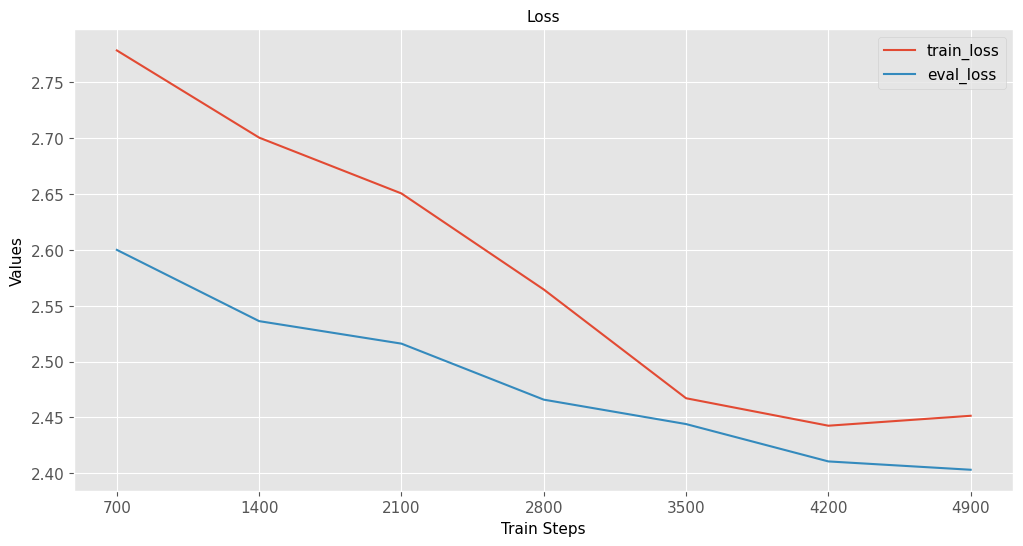

<ipython-input-44-0f672169ee5c>:135: DeprecationWarning: `magnify` needs to have value in [0,1]! `2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


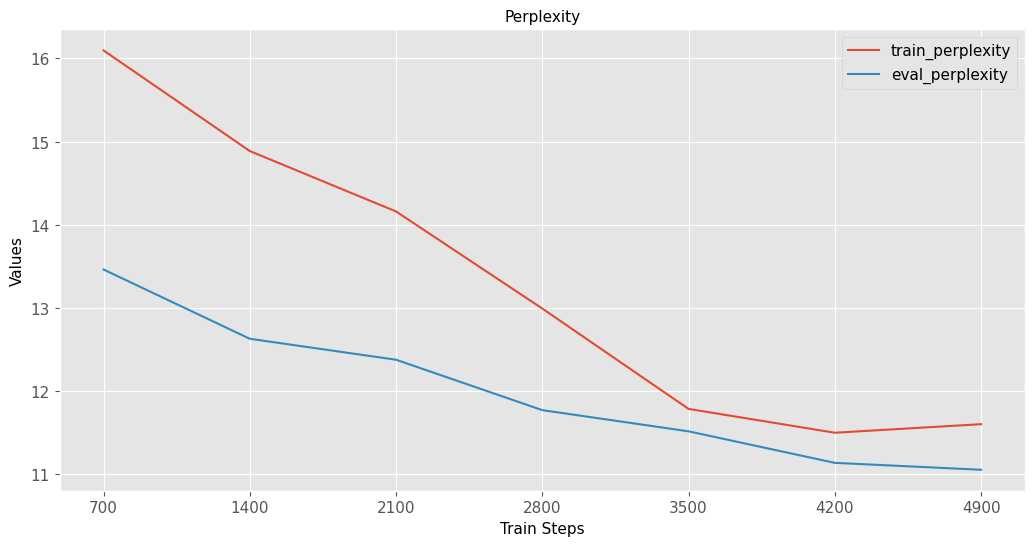

In [46]:
# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}

# Keep track of train and evaluate perplexity.
# This is a metric useful to track for language models.
perplexity_history = {'train_perplexity':[], 'eval_perplexity':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    perplexity_history['train_perplexity'].append(math.exp(log_history['loss']))

  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    perplexity_history['eval_perplexity'].append(math.exp(log_history['eval_loss']))

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps,
          step_size=training_args.logging_steps, use_title='Loss',
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

print()

# Plot Perplexities.
plot_dict(perplexity_history, start_step=training_args.logging_steps,
          step_size=training_args.logging_steps, use_title='Perplexity',
          use_xlabel='Train Steps', use_ylabel='Values', magnify=2)

## **Evaluate**

For the final evaluation we can have a separate test set that we use to do our final perplexity evaluation. For simplicity I used the same validation text file for the final evaluation. That is the reason I get the same results as the last validation perplexity plot value.

In [47]:
# check if `do_eval` flag is set.
if training_args.do_eval:

  # capture output if trainer evaluate.
  eval_output = trainer.evaluate()
  # compute perplexity from model loss.
  perplexity = math.exp(eval_output["eval_loss"])
  print('\nEvaluate Perplexity: {:10,.2f}'.format(perplexity))
else:
  print('No evaluation needed. No evaluation data provided, `do_eval=False`!')


Evaluate Perplexity:      10.97


# **Pre Train Transformer with Pytorch**

|Status|Architecture|Shortcut name|
 |:-|:-|:-|
 |Failed|BERT|bert-base-uncased|
 |Worked|BERT|bert-large-uncased|
 |Worked|BERT|bert-base-cased|
 |Worked|BERT|bert-large-cased|
 |Worked|BERT|bert-base-multilingual-uncased|
 |Worked|BERT|bert-base-multilingual-cased|
 |Worked|BERT|bert-base-chinese|
 |Worked|BERT|bert-base-german-cased|
 |Worked|BERT|bert-large-uncased-whole-word-masking|
 |Worked|BERT|bert-large-cased-whole-word-masking|
 |Worked|BERT|bert-large-uncased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-large-cased-whole-word-masking-finetuned-squad|
 |Worked|BERT|bert-base-cased-finetuned-mrpc|
 |Worked|BERT|bert-base-german-dbmdz-cased|
 |Worked|BERT|bert-base-german-dbmdz-uncased|
 |Failed|BERT|cl-tohoku/bert-base-japanese|
 |Failed|BERT|cl-tohoku/bert-base-japanese-whole-word-masking|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char|
 |Failed|BERT|cl-tohoku/bert-base-japanese-char-whole-word-masking|
 |Worked|BERT|TurkuNLP/bert-base-finnish-cased-v1|
 |Worked|BERT|TurkuNLP/bert-base-finnish-uncased-v1|
 |Worked|BERT|wietsedv/bert-base-dutch-cased|
 |Worked|GPT|openai-gpt|
 |Worked|GPT-2|gpt2|
 |Worked|GPT-2|gpt2-medium|
 |Worked|GPT-2|gpt2-large|
 |Failed|GPT-2|gpt2-xl|
 |Failed|Transformer-XL|transfo-xl-wt103|
 |Worked|XLNet|xlnet-base-cased|
 |Worked|XLNet|xlnet-large-cased|
 |Worked|XLM|xlm-mlm-en-2048|
 |Worked|XLM|xlm-mlm-ende-1024|
 |Worked|XLM|xlm-mlm-enfr-1024|
 |Worked|XLM|xlm-mlm-enro-1024|
 |Worked|XLM|xlm-mlm-xnli15-1024|
 |Worked|XLM|xlm-mlm-tlm-xnli15-1024|
 |Worked|XLM|xlm-clm-enfr-1024|
 |Worked|XLM|xlm-clm-ende-1024|
 |Failed|XLM|xlm-mlm-17-1280|
 |Failed|XLM|xlm-mlm-100-1280|
 |Worked|RoBERTa|roberta-base|
 |Worked|RoBERTa|roberta-large|
 |Worked|RoBERTa|roberta-large-mnli|
 |Worked|RoBERTa|distilroberta-base|
 |Worked|RoBERTa|roberta-base-openai-detector|
 |Worked|RoBERTa|roberta-large-openai-detector|
 |Worked|DistilBERT|distilbert-base-uncased|
 |Worked|DistilBERT|distilbert-base-uncased-distilled-squad|
 |Worked|DistilBERT|distilbert-base-cased|
 |Worked|DistilBERT|distilbert-base-cased-distilled-squad|
 |Worked|DistilBERT|distilgpt2|
 |Worked|DistilBERT|distilbert-base-german-cased|
 |Worked|DistilBERT|distilbert-base-multilingual-cased|
 |Failed|CTRL|ctrl|
 |Worked|CamemBERT|camembert-base|
 |Worked|ALBERT|albert-base-v1|
 |Worked|ALBERT|albert-large-v1|
 |Worked|ALBERT|albert-xlarge-v1|
 |Worked|ALBERT|albert-xxlarge-v1|
 |Worked|ALBERT|albert-base-v2|
 |Worked|ALBERT|albert-large-v2|
 |Worked|ALBERT|albert-xlarge-v2|
 |Worked|ALBERT|albert-xxlarge-v2|
 |Failed|T5|t5-small|
 |Failed|T5|t5-base|
 |Failed|T5|t5-large|
 |Failed|T5|t5-3B|
 |Failed|T5|t5-11B|
 |Worked|XLM-RoBERTa|xlm-roberta-base|
 |Worked|XLM-RoBERTa|xlm-roberta-large|
 |Worked|FlauBERT|flaubert/flaubert_small_cased|
 |Worked|FlauBERT|flaubert/flaubert_base_uncased|
 |Worked|FlauBERT|flaubert/flaubert_base_cased|
 |Worked|FlauBERT|flaubert/flaubert_large_cased|
 |Failed|Bart|facebook/bart-large|
 |Failed|Bart|facebook/bart-base|
 |Failed|Bart|facebook/bart-large-mnli|
 |Failed|Bart|facebook/bart-large-cnn|
 |Failed|DialoGPT|DialoGPT-small|
 |Failed|DialoGPT|DialoGPT-medium|
 |Failed|DialoGPT|DialoGPT-large|
 |Failed|Reformer|reformer-enwik8|
 |Failed|Reformer|reformer-crime-and-punishment|
 |Failed|MarianMT|Helsinki-NLP/opus-mt-{src}-{tgt}|
 |Failed|Pegasus|google/pegasus-{dataset}|
 |Worked|Longformer|allenai/longformer-base-4096|
 |Worked|Longformer|allenai/longformer-large-4096|
 |Failed|MBart|facebook/mbart-large-cc25|
 |Failed|MBart|facebook/mbart-large-en-ro|
 |Failed|Lxmert|lxmert-base-uncased|
 |Worked|Funnel Transformer|funnel-transformer/small|
 |Worked|Funnel Transformer|funnel-transformer/small-base|
 |Failed|Funnel Transformer|funnel-transformer/medium|
 |Failed|Funnel Transformer|funnel-transformer/medium-base|
 |Failed|Funnel Transformer|funnel-transformer/intermediate|
 |Failed|Funnel Transformer|funnel-transformer/intermediate-base|
 |Failed|Funnel Transformer|funnel-transformer/large|
 |Failed|Funnel Transformer|funnel-transformer/large-base|
 |Failed|Funnel Transformer|funnel-transformer/xlarge|
 |Failed|Funnel Transformer|funnel-transformer/xlarge-base|
 |Worked|LayoutLM|microsoft/layoutlm-base-uncased|
 |Worked|LayoutLM|microsoft/layoutlm-large-uncased|
 |Failed|DeBERTa|microsoft/deberta-base|
 |Failed|DeBERTa|microsoft/deberta-large|
 |Worked|SqueezeBERT|squeezebert/squeezebert-uncased|
 |Worked|SqueezeBERT|squeezebert/squeezebert-mnli|